# COMP 6981 - Term Project

## Preprocessing Stroke Prediction Data

| **Student Name**| **Student ID** | **Email** |
|---------------|------------|-----------------|
| Ghulam Haider | 202192022  | ghaider@mun.ca  |
| Lawreen Latif | 201443488  | lawreenl@mun.ca |

### Part 0: Setting up the environment

In this section we will just load all the imports for our project as well as initialise global variables (if any) so that we have one-cell-access to this information if we wish to make changes to entire notebook.

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import QuantileTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import SGDClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_classif

# Random state seed used several times in the nodebook
seed = 158

### Part 1: Dataset Presentation

In this section we are going to load our dataset and show some visual analysis of how the data looks like at a glance before we proceed with our preparation tasks.

#### 1.1: Attribute descriptors
Here we will generate descriptions of all our attributes to get and understanding of what kind of data is present in our individual attributes. There are several ways to do it, but we can take a quick glance by simply checking running the `info()` function on our pandas dataframe to begin by identifying the data types and null values count.

In [5]:
df = pd.read_csv("stroke_dataset.csv")

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         5110 non-null   int64  
 1   id                 5110 non-null   int64  
 2   gender             5110 non-null   object 
 3   age                5110 non-null   float64
 4   hypertension       5110 non-null   object 
 5   heart_disease      5110 non-null   object 
 6   ever_married       5110 non-null   object 
 7   work_type          5110 non-null   object 
 8   Residence_type     5110 non-null   object 
 9   avg_glucose_level  5110 non-null   float64
 10  bmi                4909 non-null   float64
 11  smoking_status     3566 non-null   object 
 12  stroke             5110 non-null   object 
dtypes: float64(3), int64(2), object(8)
memory usage: 519.1+ KB


By seeing the information above, we can clearly identify some key features about our dataset:
1. We have a garbage column `Unnamed: 0` which may hinder our process
2. There are 3 floating point columns and 2 integer columns
3. 6 of these columns are marked as `object` columns which could either mean mixed data type or strings
4. The 10th column `bmi` has 201 missing values
5. The 11th column `smoking_status` has 1544 missing values

#### 1.2: Attribute plots
Our next task is to draw plots of our data to see get the hints about data in each of the columns and get an idea of distribution, outliers, and missing values. Each of the data types has its own characteristic plot so we will be selecting some columns and only drawing those with respect to their data types.

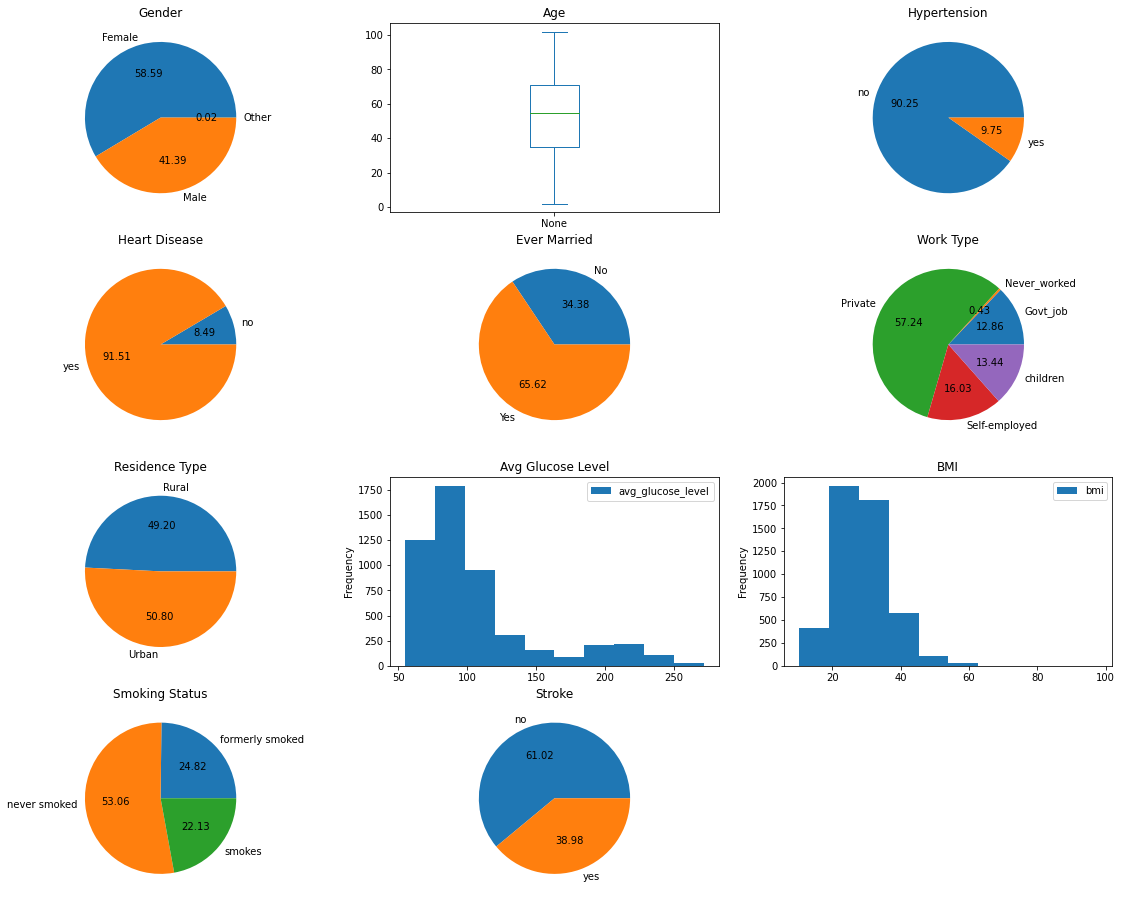

In [6]:
# We will be making a total of 11 plots, ignoring `id` and `unnamed` columns
fig, axs = plt.subplots(4, 3, figsize=(20, 16))
axs = axs.flatten()

# Gender column has object data type, assuming its just 2-3 distinct values, a pie plot would give us insight
df.groupby('gender').size().plot(kind='pie', autopct='%.2f',
                                 ax=axs[0], title='Gender', ylabel='')

# Age column obviously has age, we will make a boxplot to get useful information
df.groupby('age').size().plot(
    kind='box', ax=axs[1], title='Age', xlabel='Age (years)', ylabel='')

# Hypertension column is same as Gender, therefore we will go for pie chart
df.groupby('hypertension').size().plot(kind='pie', autopct='%.2f',
                                       ax=axs[2], title='Hypertension', ylabel='')

# Heart disease is also categorical like Gender, so we will make pie chart
df.groupby('heart_disease').size().plot(kind='pie', autopct='%.2f',
                                        ax=axs[3], title='Heart Disease', ylabel='')

# Ever married also looks like a categorical value, hence pie chart
df.groupby('ever_married').size().plot(kind='pie', autopct='%.2f',
                                       ax=axs[4], title='Ever Married', ylabel='')

# Work type is also similar to other categorical values so we will stick to one norm
df.groupby('work_type').size().plot(kind='pie', autopct='%.2f',
                                    ax=axs[5], title='Work Type', ylabel='')

# Residence type is also a categorical value so we will make a pie chart
df.groupby('Residence_type').size().plot(kind='pie', autopct='%.2f',
                                         ax=axs[6], title='Residence Type', ylabel='')

# Average glucose level is a floating value so we will make a histogram with (default) 10 bins
pd.DataFrame(df, columns=['avg_glucose_level']).plot(
    kind='hist', ax=axs[7], title='Avg Glucose Level', ylabel='')

# BMI is also floating point value so we will do same as above, histogram with 10 bins
pd.DataFrame(df, columns=['bmi']).plot(
    kind='hist', ax=axs[8], title='BMI', ylabel='')

# Smoking status is again a categorical value so we will draw pie chart again
df.groupby('smoking_status').size().plot(kind='pie', autopct='%.2f',
                                         ax=axs[9], title='Smoking Status', ylabel='')

# Lastly, our target variable is Stroke which is also a categorical value so we will plot a pie
df.groupby('stroke').size().plot(kind='pie', autopct='%.2f',
                                 ax=axs[10], title='Stroke', ylabel='')

# Our last axis is empty so we will turn it off for better output
axs[11].axis('off')
plt.show()


#### 1.2: Analysing the plots

By looking at the plots above, we can see some interesting information in all of our attributes. Lets take a look at them one by one:
1. In the `Gender` column, we have 3 genders, roughly 58% of this study participants were females and 41% were males, while 0.02% were identified as other genders. Here we can see that other gender can be considered outliers for our column.
2. The `Age` column shows that the participants ranged between ages of roughly 38 years to 70 years
3. The `Hypertension` column shows roughly 10% of the participants did have hypertension
4. The `Heart diseas` column shows that more than 90% of the participants had haert disease
5. More than 65% of the participants were married as seen in `Ever Married` plot
6. In the `Work type` plot we can see that 0.43% of the participants never worked, which could be identified as outliers
7. In the `Residence type` we see that the study was roughly divided 50/50 between urban and rural
8. The `Avg glucose level` plot shows that a few of the participants had glucose levels ranging beyond 220, which could be considered as outliers
9. We again have some outliers in `BMI` column where some values range beyond 50
10. The `Smoking status` plot shows a fair distribution where more than half of participants never smoked
11. Lastly the `Stroke` column shows that our target column has no outliers or missing values

#### 1.3: Handling outliers and missing values

Now that we have an understanding of each of our attributes, we can proceed to edit our data. First step is to remove any unecessary columns, then remove missing value rows, and finally handle the outliers in the most feasible way.

Shape before: (5110, 13)
	After dropping columns: (5110, 11)
	After dropping 1684 missing values: (3426, 11)
	After dropping 543 outliers: (2883, 11)


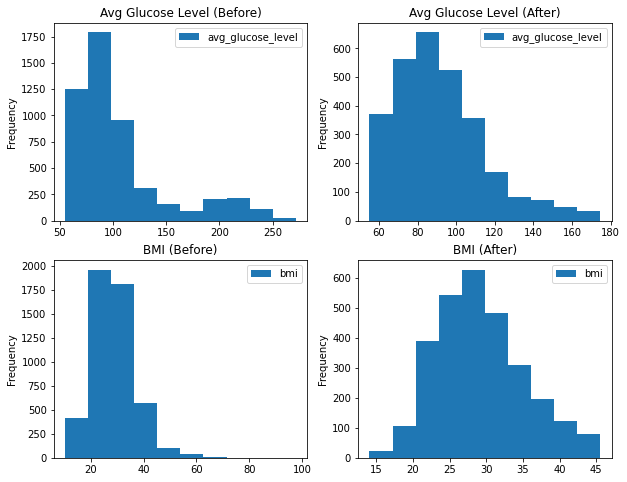

In [7]:
print(f'Shape before: {df.shape}')

# First we will drop the unnamed and id columns as those are of no use here
df_clean = df.drop(columns=["Unnamed: 0", "id"]).copy()
print(f'\tAfter dropping columns: {df_clean.shape}')

# Before dropping the missing values, we will extract them for later processing in Part 3
null_data = df_clean[df_clean.isnull().any(axis=1)]

# Now we will drop the null values
df_clean = df_clean.dropna()
print(f'\tAfter dropping {len(null_data)} missing values: {df_clean.shape}')

# Now we will handle the outliers. Based on our visual analysis, we know the columns that potentially contain outliers
# Out of the several ways to remove outliers, it is up to us as to which technique we use
# Here we will remove any values beyond our 1.5 times the IQR


def drop_outliers_beyond_iqr(df, columns):
    for c in columns:
        Q1 = df[c].quantile(0.25)
        Q3 = df[c].quantile(0.75)
        IQR = Q3 - Q1
        df = df.loc[(df[c] > Q1 - 1.5*IQR) & (df[c] < Q3 + 1.5*IQR)]
    return df


# We need to save outliers_data for later processing in Part 3
df_droppedoutliers = drop_outliers_beyond_iqr(
    df_clean, ['avg_glucose_level', 'bmi'])
outliers_data = pd.concat(
    [df_droppedoutliers, df_clean]).drop_duplicates(keep=False)
df_clean = df_droppedoutliers
print(f'\tAfter dropping {len(outliers_data)} outliers: {df_clean.shape}')

# Now lets compare our outlier removal results side by side with original df
fig, axs = plt.subplots(2, 2, figsize=(10, 8))
axs = axs.flatten()

# Plot the old and new graphs of the selected columns to see the difference
pd.DataFrame(df, columns=['avg_glucose_level']).plot(
    kind='hist', ax=axs[0], title='Avg Glucose Level (Before)', ylabel='')
pd.DataFrame(df_clean, columns=['avg_glucose_level']).plot(
    kind='hist', ax=axs[1], title='Avg Glucose Level (After)', ylabel='')
pd.DataFrame(df, columns=['bmi']).plot(
    kind='hist', ax=axs[2], title='BMI (Before)', ylabel='')
pd.DataFrame(df_clean, columns=['bmi']).plot(
    kind='hist', ax=axs[3], title='BMI (After)', ylabel='')
plt.show()


Interesting results. We can clearly see how effective the IQR replacement was for us. It did not only scale down our data significantly, but it also handled the outlier values on both ends giving us a better distribution over the readings. In case of `Avergae Glucose Level` we did lose quite a bit of readings but since those were beyond 1.5 times our IQR, we can assume that those values would have affected our data analysis otherwise.

Secondly for `BMI` we see that IQR transformation did quite well, giving us almost a normalised distribution over a smaller scale. This will surely impact our further data preparation positively.

### Part 2: Data Scaling

Next we wil attempt to scale our data and see which scaling technique does better for us based on multiple training techniques on the scaling methods.

#### 2.1: Encoding categorical data

Before we begin doing any training or scaling, we first need to convert our categorical values to numeric values using `LabelEncoder` by Sklearn. Looking at the features, we see that none of the categorical features really need any ordinal encoding, therefore we will stick with LabelEncoder. This will allow for our models to train better on numeric-only data.

In [8]:
# For the sake of comparison, we will show original form first
print('Before encoding')
df_clean.head(5)

Before encoding


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,Male,80.0,no,yes,Yes,Private,Rural,105.92,32.5,never smoked,yes
3,Female,49.0,no,yes,Yes,Private,Urban,171.23,34.4,smokes,yes
4,Female,79.0,yes,no,Yes,Self-employed,Rural,174.12,24.0,never smoked,yes
6,Male,74.0,yes,yes,Yes,Private,Rural,70.09,27.4,never smoked,yes
7,Female,69.0,no,yes,No,Private,Urban,94.39,22.8,never smoked,yes


In [9]:
# Here we also want to encode the outliers and missing dfs that have been extracted out from our base df
# We create an encoder on df_base then apply the same encoder on dfs_derived as well
# This perserves the values of the attributes

def encode_values(df_base, dfs_derived, columns):
    label_encoder = LabelEncoder()
    for c in columns:
        # Just create the fit on base data
        label_encoder.fit(df_base[c])

        # Now apply the fit and transform both the base and the derived dataframes
        df_base[c] = label_encoder.transform(df_base[c])
        for df in dfs_derived:
            # Tricky solution to apply label encoder despite having NaN values
            series = df[c]
            df[c] = pd.Series(
                label_encoder.fit_transform(series[series.notnull()]),
                index=series[series.notnull()].index
            )
    return df_base, dfs_derived

# We will be referencing the extracted_encoded in Task 3
df_encoded, extracted_encoded = encode_values(df_clean.copy(), [null_data.copy(), outliers_data.copy()], ['gender', 'hypertension', 'heart_disease',
              'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke'])

# Overwrite the null_data and outliers_data so that same encoder has been applied on them
null_data = extracted_encoded[0]
outliers_data = extracted_encoded[1]

# Let's compare our data now
print('After encoding')
df_encoded.head(5)

After encoding


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
2,1,80.0,0,1,1,2,0,105.92,32.5,1,1
3,0,49.0,0,1,1,2,1,171.23,34.4,2,1
4,0,79.0,1,0,1,3,0,174.12,24.0,1,1
6,1,74.0,1,1,1,2,0,70.09,27.4,1,1
7,0,69.0,0,1,0,2,1,94.39,22.8,1,1


#### 2.2: Dataset split

We are going to split our `df_encoded` data to get train and test splits which will be used in our scaling methods. For this task, we will use the `traing_test_split` method provided by Sklearn.

In [10]:
# Define our target and learn columns
target_column = 'stroke'
learn_columns = [x for x in df_encoded.columns if x != target_column]

# Define our target and train data
X, y = df_encoded[:][learn_columns], df_encoded[:][target_column]

# Define our train and test splits using sklearn's train_test_split() method giving 20% data to testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, shuffle=True)

# Let's analyse what we have extracted so far
print('Shape of X_train:', X_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train: (2306, 10)
Shape of X_test: (577, 10)
Shape of y_train: (2306,)
Shape of y_test: (577,)


Now we can proceed with our scaling techniques. To get best scaling results, we will compare multiple scaling techniques paired with multiple training methods so that we can get best combination and decide our results in the best possible way. We will be using two models for the comparison:

1. `SGDClassifier` which will give us results for linear training
2. `KNeighboursClassifier` which will give us results for KNN classification

Both these models will be paired with following scaling techniques:

1. `MinMaxScaler` Will try to scale our values between a given range (0-1)
2. `StandardScaler` Will help both age and Avg Glucose Level columns to scaled form while also affecting bmi column
3. `MaxAbsScaler` Will try to cap out our excess data at the end of Avg Glucose Level column
4. `RobustScaler` Will scale the data according to IQR
5. `QuantileTransformer` Will also scale the values based on quantiles

All these scalers focus on bringing the columns to same (or similar) scales so that our models can perform better especially in the case of models that rely on distance measurement.

The comparison will be based on `Accuracy` measure of the performing combinations.

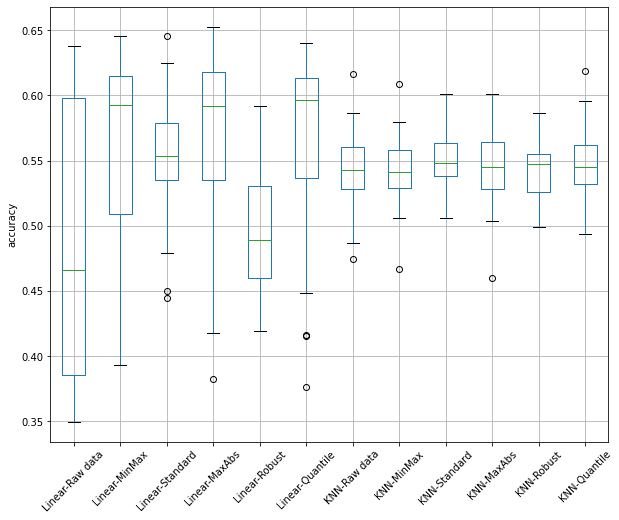

In [36]:
def compare_scaling_effects(
        X, y, models, model_slugs,
        scalers=[MinMaxScaler(), StandardScaler(), MaxAbsScaler(),
                 RobustScaler(), QuantileTransformer()],
        scaler_slugs=['MinMax', 'Standard', 'MaxAbs', 'Robust', 'Quantile'],
        metric='accuracy'):

    # Prepend raw data into our scalers list
    scaler_slugs.insert(0, 'Raw data')
    X_dfs = [X]

    # Apply all scalers and fit with given X, returns ndarray
    scaled = [scaler.fit_transform(X) for scaler in scalers]

    # Convert the M ndarrays back to original form of data frame
    X_dfs += [pd.DataFrame(fitted_X, index=X.index, columns=X.columns)
              for fitted_X in scaled]

    # Initiate repeated k-fold validator to use among all cross_val_scores()
    validator = RepeatedKFold(n_splits=10, n_repeats=5, random_state=1)

    # Save Mxn outcomes externally for later draw
    df_outcomes = pd.DataFrame()
    for i in range(len(models)):
        for j in range(len(X_dfs)):
            # Apply cross_val_score one by one
            # We use string names (MODEL-SCALER) as index of our outcomes df
            df_outcomes[model_slugs[i] + '-' + scaler_slugs[j]] = cross_val_score(
                models[i], X_dfs[j], y, scoring=metric, cv=validator, n_jobs=-1)

    # Plot our outcomes calculated above
    boxplot = df_outcomes.boxplot(figsize=(10, 8))
    boxplot.set_ylabel(metric)
    plt.xticks(rotation=45)
    plt.show()


# Call our function with necessary attributes
compare_scaling_effects(X_train, y_train, [SGDClassifier(
    loss="squared_error", penalty="l2", max_iter=10000000), KNeighborsClassifier(n_neighbors=3)], ['Linear', 'KNN'])


#### 2.3: Analysis

Looking at the graph above, we can see the effects of scaling the data as compared to our original data set. Looking at the 12 combination results, we can understand the following:

* Right at the first look we can see that scaling techniques really shrunk the IQR of our model accuracy which is indeed the effect of scaling
* Looking at a glance, the KNN models did fairly similar across all scaling techniques, where the mean accuracy mostly ranged between 52-53%
* The Linear models did vary in terms of performance with difference scalers, where the mean accuracy ranged between ~52-58%
* The best performing combination looks to be `Linear-MinMax` where we get a peak mean accuracy of roughly 58%

### Part 3: Handling missing data and outliers

In this section we will work with the missing data and outliers. Here we will reuse the `null_data` and `outliers_data` variables that we prepared in Part 1. We will combine these back with our original data and run some methods to fill missing data and deal with the outliers. We will be using `df_encoded` data frame as our baseline data here.

In [23]:
# We will first merge the extracted values back with our dataframe
df_merged = pd.concat([df_encoded, outliers_data, null_data])

# Now our dataframe is back to original number of rows, resembling our initial info() output
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     3566 non-null   float64
 10  stroke             5110 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 479.1 KB


#### 3.1: Filling the missing data

There are several techniques provided by pandas to fill our data such as forward fill, backward fill, filling with a specific scalar, etc. In our case, we will be filling our missing data with `mean` value due to several reasons:

1. As we were told to _extract_ the data in Part 1, we have lost the original position of our data. After merging back with our dataframe in previous cell, the extracted values are appended to the end of our data. Here the forward fill and backward fill are not quite possible (unless we shuffle the data which would bias the fill), therefore we are going for the mean fill.
2. One of the missing values attribute, `bmi`, is already in somewhat of a normalised shape, so it only makes sense to fill the missing values with the mean data.
3. As for the second attribute, `smoking_status`, we have encoded them to numeric data, so it is fair enough to just take mean and fill the missing values with that.

In [37]:
# For the sake of analysis, we will locate the null-value rows
bmi_null_ids = np.where(df_merged['bmi'].isnull())[0]
ss_null_ids = np.where(df_merged['smoking_status'].isnull())[0]

# Now apply the filling method on our merged df
df_filled = df_merged.fillna(df_merged.mean())

# Let's see our null value data now
df_filled.iloc[np.concatenate([bmi_null_ids, ss_null_ids])]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1,0,61.0,0,1,1,3,0,202.21,28.893237,1.000000,1
8,0,59.0,0,1,1,2,0,76.15,28.893237,0.973079,1
13,1,78.0,0,1,1,2,1,219.84,28.893237,0.973079,1
19,1,57.0,0,1,0,0,1,217.08,28.893237,0.973079,1
27,1,58.0,0,1,1,2,0,189.84,28.893237,0.973079,1
...,...,...,...,...,...,...,...,...,...,...,...
5098,1,9.0,0,1,0,4,1,71.88,17.500000,0.973079,1
5101,0,45.0,0,1,1,2,1,97.95,24.500000,0.973079,0
5103,0,18.0,0,1,0,2,1,82.85,46.900000,0.973079,0
5104,0,13.0,0,1,0,4,0,103.08,18.600000,0.973079,1


Now we will plot this data and see visually where the missing values lie, and compare with the filled values.

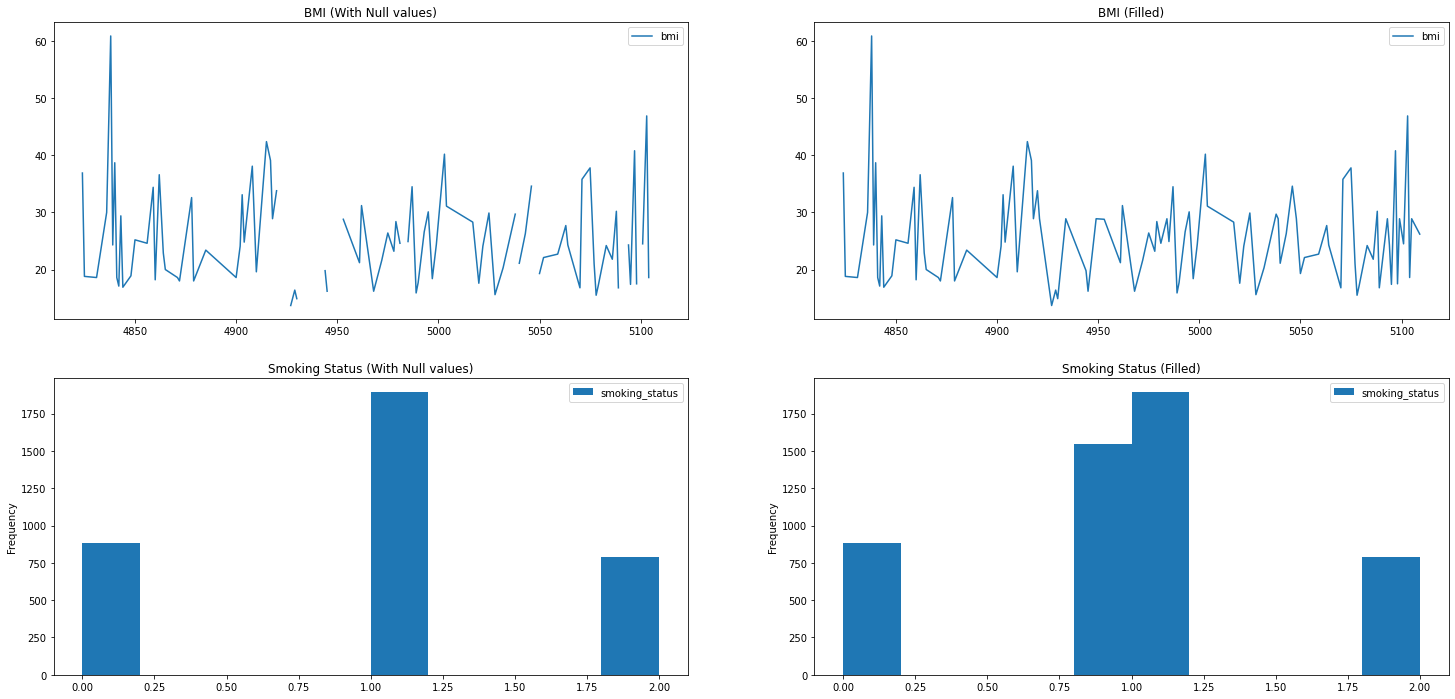

In [38]:
fig, axs = plt.subplots(2, 2,figsize=(25,12))
axs = axs.flatten()

# Since we have 5000+ rows, the line plot will mess up the output
# We know that our missing values were appended at the very end, let's see the last 100 rows
pd.DataFrame(df_merged.iloc[-100:], columns=['bmi']).plot(kind='line', ax=axs[0], title='BMI (With Null values)', ylabel='')
pd.DataFrame(df_filled.iloc[-100:], columns=['bmi']).plot(kind='line', ax=axs[1], title='BMI (Filled)', ylabel='')

pd.DataFrame(df_merged, columns=['smoking_status']).plot(kind='hist', ax=axs[2], title='Smoking Status (With Null values)', ylabel='')
pd.DataFrame(df_filled, columns=['smoking_status']).plot(kind='hist', ax=axs[3], title='Smoking Status (Filled)', ylabel='')

plt.show()

Here we can clearly see that our missing data columns have been filled with the mean values. In case of `smoking_status`, since most of our respondents were non smokers, the filled value is biased towards non smokers. Similarly for the `bmi`, we have filled it with the mean data which maintains the characteristic of somewhat of a normalised fill.


#### 3.2: Deciding upon a classifier-scaler combination

Now after filling the missing values, we have to deal with outliers. The best way to fix outliers is by using a classification model to replace those values with the most appropriate one. For the sake of this replacement, we first need to see which classifier technique works best with our new filled dataset, ignoring the outlier rows that we have.

For this comparison, we will be using `accuracy` measure as that tells us how good the prediction was for our model that we train on the data.

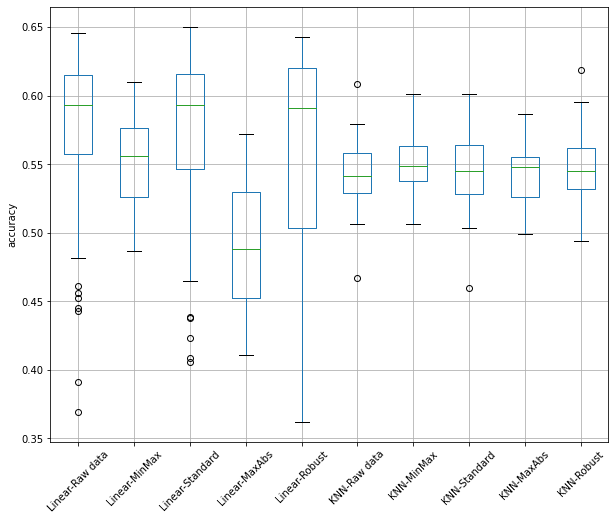

In [39]:
# Define new train test split based on our modified data
X, y = df_filled[:][learn_columns], df_filled[:][target_column]

# Define our train and test splits using sklearn's train_test_split() method giving 20% data to testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=seed, shuffle=True)

compare_scaling_effects(X_train, y_train, [SGDClassifier(
    loss="squared_error", penalty="l2", max_iter=10000000), KNeighborsClassifier(n_neighbors=3)], ['Linear', 'KNN'])

Now we see that our data is performing somewhat better on `Linear-Robust` combination as well, as opposed to our initial assumption in Section 2.2 where we decided to go with Linear-MinMax. Moreover, we clearly see where the outliers stand in these boxplot graphs. Now we can use this combination to replace the outliers in our dataset.

#### 3.3: Filling the outliers

In this section we will use the analysis from above and fill out our outliers that we extracted before in `outliwers_data` variable. This will give us a more normalised data with no outliers in them.

In [40]:
def predict_outliers(df_base, df_target, column_target):
    # We will be using our preselected combination of scaler and classifier
    scl = RobustScaler()
    model = SGDClassifier(loss="squared_error", penalty="l2", max_iter=10000000)

    # Split the df so that we isolate target column on the base df
    X = df_base.drop([column_target], axis=1).to_numpy()
    X_t = scl.fit_transform(X)
    y = df_base[column_target].astype(int).to_numpy()

    # Now we train our model with the data
    model.fit(X_t, y)

    # Here we will forecast the outlier values
    X_pred = scl.transform(df_target.drop([column_target], axis=1).to_numpy())
    y_pred = model.predict(X_pred)

    # Finally, we will replace the outliers with predicted values
    df_target[column_target] = y_pred
    return df_target

# We will call the above function twice for both outlier-containing columns
predicted1 = predict_outliers(df_encoded.copy(), outliers_data.copy(), 'bmi')
predicted2 = predict_outliers(df_encoded.copy(), predicted1.copy(), 'avg_glucose_level')

# Now we will merge again with our base dataframe but this time with new values for outliers
df_merged_predicted = pd.concat([df_encoded, predicted2, null_data])
df_merged_predicted = df_merged_predicted.fillna(df_merged_predicted.mean())

df_merged_predicted.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 2 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   int64  
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   int64  
 5   work_type          5110 non-null   int64  
 6   Residence_type     5110 non-null   int64  
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                5110 non-null   float64
 9   smoking_status     5110 non-null   float64
 10  stroke             5110 non-null   int64  
dtypes: float64(4), int64(7)
memory usage: 479.1 KB


### Part 4: Feature Selection

This section focuses on extracting the best possible features from our dataset so that we can only use a subset of features to get the best possible results for our models. 

Here are the metrics that we will be using:

* `f_classif` will be used to identify the variance between sample means. This is particularly useful for the case of categorical classification such as our case.
* `mutual_info_classif` is also a useful scoring measure when we are comparing categorical classification techniques. This score tells us the relation between selected variables and our target variable.
* From the previous sections we have seen that `SGDClassifier` performs fairly better than others on our data set, so we will be using this model for the sake of comparison between n-nest features to use.
* We will be running our model one by one on `3, 5, and 8` best features, finally running on baseline `all` features to see which selection gives us more accurate results.
* For the sake of visualisation, we will be using `accuracy` metric to see the performance of our model.
* For the cross validator, we will be using `RepeatedKFold` with 5 splits and 5 repeats.

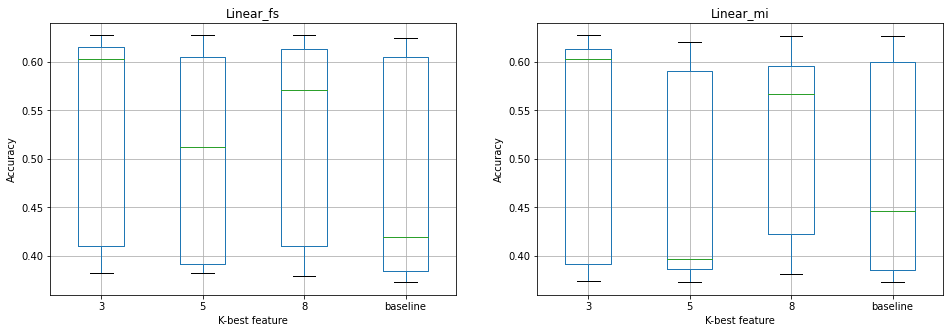

In [59]:
# Prepare cross validator instance
cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=321)

# Set the k-values for SelectKBest, 'all' refers to our baseline model
k_best = [3, 5, 8, 'all']

# Set the scoring functions to use
scoring_funcs = [f_classif, mutual_info_classif]
scoring_func_names = ["fs", "mi"]

fig, axs = plt.subplots(1, 2, figsize=(16, 5))
axs = axs.flatten()
fig_idx = 0

X_vals = df_merged_predicted.drop([target_column], axis=1).to_numpy()
y_vals = df_merged_predicted[target_column].astype(int).to_numpy()

# From Task 3 we know that SGDClassifier does better than KNN or other models
classifier, classifier_name = SGDClassifier(loss="squared_error", penalty="l2", max_iter=10000000), 'Linear'
for j in range(len(scoring_funcs)):
    scoring_func, scoring_func_name = scoring_funcs[j], scoring_func_names[j]
    results = {}
    for k in range(len(k_best)):
        k_val = k_best[k]

        # Select k-best features using the iterating scoring function
        selected = SelectKBest(score_func=scoring_func, k=k_val)

        # Reshape our X dataframe to selected features
        X_sel = selected.fit_transform(
            X_vals, y_vals)

        # Calculate scores on the (looping) classifier
        scores = cross_val_score(classifier, X_sel, y_vals, scoring='accuracy', cv=cv, n_jobs=-1)

        # Save the results outside of this loop so we can plot all at once
        results[f'{k_val if k_val != "all" else "baseline"}'] = scores

    # Convert the results dict() to pandas dataframe and make a copy
    df_res = pd.DataFrame(results).copy()

    # Plot the results
    df_res.boxplot(ax=axs[fig_idx])
    axs[fig_idx].set_title(f'{classifier_name}_{scoring_func_name}')
    axs[fig_idx].set_ylabel("Accuracy")
    axs[fig_idx].set_xlabel("K-best feature")
    fig_idx += 1
plt.show()


Here we clearly see that in both scoring methods, fclassif and mutual information, our model performs best on `3 best features` rather than all or any lesser. This is a good finding since now we can use only 3 features rather than all 13 and we would still achieve fairly good model performance.

#### Conclusion:

In this notebook we initially took a raw dataset and visualised all its attributes. The intial analysis gave us an insight of how raw data can contain unnecessary/lack of information and would require preprocessing or cleaning. We then dropped unnecessary features, missing values, and eventually scaled our data so it is more normalised. After scaling, we converted categorical (string) values to numeric values so that we can train ML models during the process of data preparation. After encoding the categorical values, we ran multiple ML models to predict missing values and reset outliers to better fit our data. Finally after fixing the outliers and missing values, we ran analysis to determine only the relevant subset of features to use rather than all.

This entire process gives us an insight of how real world data can (mostly) never be used in raw form, and how it almost always requires heavy preprocessing and cleaning approaches. The data cleaning approaches we used here lead to a much better and feasible data set which can lead to better trained models and techniques.